# Hito 1

## 1. Preliminares

A continuación se detallan las características del problema a evaluar.

### 1.1 Problema (Análisis de sentimientos en Twitter)

El problema corresponde a uno de análisis de texto, donde queremos identificar el sentimiento asociado a un texto; el cual se refiere a un tweet.

Dado ello, es un problema de clasificación.

Objetivo: identificar si un tweet tiene polaridad positiva o negativa (sentimiento expresado).

* Variable objetivo: describe una emocion que resume el contenido de un tweet. Para conveniencia del trabajo, estas serán transformadas a emociones positivas o negativas de acuerdo a su morfología.

* Atributos: inicialmente existen textos que son tweets escritos en la plataforma de Twitter. Sin embargo, con objetivo de crear atributos para la predicción de emociones, transformaremos dichos textos en vectores de ocurrencia.

### 1.2 Modelos a implementar

Dado que el problema a estudiar es un problema de clasificación, proponemos la implementación de los siguientes modelos:

* Logistic Regression: método de clasificación que presente una fácil implementación y en general, un buen desempeño.

* Decision Tree: algoritmo condicional que permite construir predicciones a partir de preguntas sobre el conjunto de datos

* Random Forest Classifier: dado que es un buen predictor para clasificadores al promediar el desempeño de un grupo de clasificadores, e implementa un proceso de validación cruzada con un sample menor al número total de atributos disponibles; permitiendo evaluar el desempeño "out-of-bag" en cada iteración.

* Gradient Boosting: algoritmo que ajusta los pesos asociados a cada atributo en cada iteración en base al error residual que esta teniendo el modelo. A medida que aumentan las iteraciones, la función objetivo acoplada en los residuos tiende a situarse cercano a cero.

* Ada Boost: algoritmo de ensamble adaptativo que usará como base árboles de decisión, y disminuye el error en las predicciones del modelo asignando pesos mayores en cada iteración a los atributos con mayor error. De esta forma podrá mejorar su capacidad predictiva

Dado los algoritmos presentados anteriormente, se definen los siguientes parámetros de grilla:

*  Logistic Regression: 

    params = {
        'C': np.logspace(-4, 4, 10),
        'penalty': ['l1', 'l2']}

* Decision Tree:

    params = {
            'max_depth': [2, 5, 10]
            }

* Random Forest Classifier:

    params = {
        n_estimators = range(20, 1000, 10),
        'max_features': ['log2', 'sqrt']}

* Gradient Boosting:

    param_grid = {'n_estimators': [100, 500, 1000],
                'learning_rate': [0.1, 0.5, 1, 5],
                'subsample': np.linspace(0.1, 1.0, 3, endpoint=True, dtype=float)}

### 1.3 Métricas y estrategia de división de muestras

Las métricas a utilizar para este problema de clasificación serán:

* accuracy_score: define el ratio de asignaciones correctas

* roc_auc_score: curva que permite comparar la clasificación de nuestro modelo con un clasificador aleatorio

* confusion_matrix: matriz que nos permite identificar tanto las asignaciones correctas como las que no; separadas por clase

* classification_report: reporte que nos brinda el Precision (porcentaje de clasificaciones correctas entre las asignadas), Recall (porcentaje de una clase que somos capaces de identficar correctamente), F1-score (ponderacion entre Precission y Recall) y Accuracy (igual a accuracy_score) de nuestro modelo

Por otro lado, para dividir nuestro conjunto de datos utilizaremos el módulo "train_test_split()" de scikit-learn. Utilizaremos un 33% del set de datos como conjunto validador y además utilizaremos una semilla pseudo-aleatoria para poder replicar los resultados.

### 1.4 Procesamiento tentativo

* Se eliminarán las filas que posean ya sea el tweet o la emoción incompleta, ya que pierde las características mínimas necesarias para participar del proceso predictivo

* Se aplicarán técnicas de procesamiento de lenguaje natural (NLP) para hacer una limpieza inicial de los tweets considerando: normalización de tweets a minúscula, eliminación de caracteres especiales, lematización, entre otros

* Se utilizará el módulo de scikit-learn TfidfVectorizer o CountVectorizer para transformar los tweets en vectores numéricos

* Las etiquetas neutras serán clasificadas como negativas el 51% de las veces, y positivas el 49%. Esto dado las probabilidades proporcionales iniciales de dichas clases y además, dado que la emoción neutra no aporta características relevantes al modelo

## 2. Aspectos Computacionales

In [89]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

from static import *

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

## 3. Feature Engineering

In [2]:
# lectura de datos
data = pd.read_csv('training_tweets.csv').drop('Unnamed: 0', axis=1)

### 3.1 limpieza de tweets

In [3]:
# aplicando normalización y lemmatizacion a los tweets
df_clean = nlp_cleaning(data)

In [4]:
df = df_clean.loc[:, ['content_clean', 'sentiment']]
df.rename(columns={'content_clean': 'content'}, inplace=True)

### 3.2 Transformando emociones

In [5]:
emotion_dict = {
    'worry': 'negativa',
    'happiness': 'positiva',
    'sadness': 'negativa',
    'love': 'positiva',
    'surprise': 'positiva',
    'fun': 'positiva',
    'relief': 'positiva',
    'hate': 'negativa',
    'empty': 'negativa',
    'enthusiasm': 'positiva',
    'boredom': 'negativa',
    'anger': 'negativa'
}

In [6]:
# reemplazando emociones
df['sentiment'] = df['sentiment'].replace(emotion_dict)

In [7]:
# probabilidad inicial de emociones
df['sentiment'].value_counts('%')

negativa    0.400733
positiva    0.384233
neutral     0.215033
Name: sentiment, dtype: float64

In [8]:
# reemplazando emocion neutral
binary = ['negativa', 'positiva']
df['sentiment'] = [i.replace('neutral', np.random.choice(binary, 1, p=[0.51, 0.49])[0]) for i in df['sentiment']]

In [10]:
df['sentiment'].value_counts('%')

negativa    0.511967
positiva    0.488033
Name: sentiment, dtype: float64

### 3.3 Transformamos el conjunto de datos en una matriz que represente la ocurrencia de cada palabra

In [11]:
# Create a Vectorizer Object
vectorizer = CountVectorizer()

In [12]:
# ajustamos el modelo con los
X = vectorizer.fit_transform(df['content'])

In [13]:
df_count = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [14]:
# reducimos el espacio eliminando palabras insignificantes
df_count = df_count.iloc[:, 899:-5]

In [15]:
# juntamos los conjuntos de datos
x_attr = df_count.copy()

In [20]:
df_model = x_attr.copy()
df_model['variable_objetivo'] = df['sentiment']

# 4. Análisis Exploratorio

A continuación indagamos sobre la estructura inicial de nuestro conjunto de datos en cuanto a contenido.

### 4.1 Distribución de clases en vector objetivo

<AxesSubplot:xlabel='sentiment', ylabel='count'>

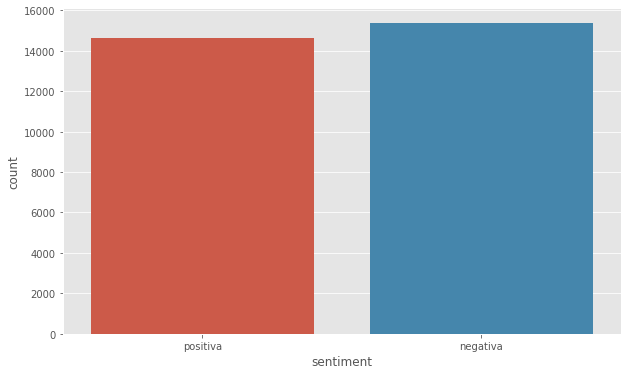

In [23]:
sns.countplot(x=df['sentiment'])

A partir del gráfico anterior identificamos que las clases de emociones: positiva, y negativa; se encuentran balanceadas.

### 4.2 Palabras más comunes

In [24]:
# dataframe con palabras y el número de veces que están presente en tweets
words = vectorizer.get_feature_names()
words_freq = X.toarray().sum(axis=0)
words_freq_df = pd.DataFrame([list(words), list(words_freq)]).T

In [25]:
# obtenemos las 5000 palabras más comunes
words_freq_df.columns= ['word', 'freq']
words_freq_df = words_freq_df.sort_values(by='freq', ascending=False).iloc[0:5000, :].reset_index(drop=True)

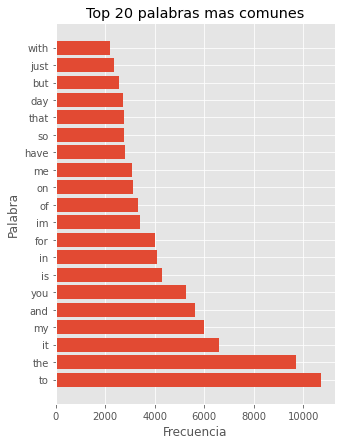

In [26]:
# visualizamos la distribucion de las 20 palabras con mayor uso
plt.figure(figsize=(5, 7))
plt.barh(words_freq_df['word'][:20], words_freq_df['freq'][:20])
plt.title('Top 20 palabras mas comunes')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()

### 4.3 Palabras más comunes por categoría

In [27]:
# eliminando columnas duplicadas
df_model = df_model.loc[:, ~df_model.columns.duplicated()].copy()

In [44]:
# contamos numero de palabras por emocion
df_comun = df_model.groupby('variable_objetivo').sum().reset_index()

In [46]:
df_comun.head()

,variable_objetivo,antibiotic,antic,anticipate,anticipated,anticipating,anticipation,antidisestablishmentarianism,antigravity,antiitch,...,zstanu,zu,zuccini,zuljin,zulu,zuluxhosa,zum,zumba,zune,zwarte
0,negativa,3,0,0,1,2,0,1,1,1,...,1,2,1,1,0,1,0,1,2,1
1,positiva,0,1,1,0,2,2,0,0,0,...,0,0,0,0,1,0,1,0,3,0


In [50]:
df_comun = df_comun.T.iloc[1:, :]
df_comun.columns = ['negativa', 'positiva']

In [52]:
df_negative = df_comun.loc[:, 'negativa']
df_positive = df_comun.loc[:, 'positiva']

#### palabras mas comunes en emocion negativa

In [53]:
df_negative.sort_values(ascending=False).head(20)

to      5760
the     4905
it      3499
my      3349
is      2355
you     2342
in      2187
im      2002
for     1878
me      1726
of      1717
on      1606
but     1552
have    1519
so      1508
that    1499
not     1321
just    1185
be      1176
at      1120
Name: negativa, dtype: object

#### palabras mas comunes en emocion positiva

In [54]:
df_positive.sort_values(ascending=False).head(20)

to      4981
the     4808
it      3099
you     2924
my      2656
for     2139
is      1958
in      1913
day     1711
of      1616
on      1508
im      1405
me      1365
have    1283
so      1271
that    1264
with    1213
just    1175
good    1101
love    1046
Name: positiva, dtype: object

# Hito 2

## Separamos en conjuntos de entrenamiento y validación

In [78]:
vo_dict = {'negativa': 0, 'positiva': 1}

df_model['variable_objetivo'] = df_model['variable_objetivo'].replace(vo_dict)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(x_attr, df_model['variable_objetivo'], test_size=.33, random_state=23679)

## Estandarizamos los datos con scikit-learn

In [83]:
# estandarizamos conjunto de entrenamiento y testeo
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)


## Búsqueda de Grillas para modelos

In [85]:
# diccionario que permitirá acceder a modelos y grillas

model_grid_dict = {
    LogisticRegression(): {'C': np.logspace(-2, 2, 4), 'penalty': ['l1', 'l2']},
    KMeans(): {'n_clusters': [2, 3, 4, 5]},
    LinearDiscriminantAnalysis(): {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7]},
    RandomForestClassifier(): {'n_estimators': range(20, 1000, 10), 'max_features': ['log2', 'sqrt']},
    GradientBoostingClassifier(): {'n_estimators': [100, 500, 1000], 'learning_rate': [0.1, 0.5, 1, 5], 'subsample': np.linspace(0.1, 1.0, 3, endpoint=True, dtype=float)}
}

In [87]:
i = 0
for model_, params_ in model_grid_dict.items():
    if i < 2:
        get_params = GridSearchCV(model_, params_, cv=2, n_jobs=-1, verbose=0)
        get_params.fit(X_train, y_train)
        best_model = get_params.best_estimator_.fit(X_train, y_train)
        print(f'Modelo predictivo: {model_}')
        print(f'Best params: {get_params.best_params_}')
        print(f'Best score: {get_params.best_score_}')
        print(classification_report(y_test, best_model.predict(X_test)))
        i += 1

/Users/gonzalooportus/.virtualenvs/venv-ml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gonzalooportus/.virtualenvs/venv-ml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Modelo predictivo: LogisticRegression()
Best params: {'C': 0.21544346900318834, 'penalty': 'l2'}
Best score: 0.6675621890547263
              precision    recall  f1-score   support

           0       0.69      0.72      0.70      5092
           1       0.69      0.65      0.67      4808

    accuracy                           0.69      9900
   macro avg       0.69      0.69      0.69      9900
weighted avg       0.69      0.69      0.69      9900

Modelo predictivo: KMeans()
Best params: {'n_clusters': 5}
Best score: -110809.35407548108
              precision    recall  f1-score   support

           0       0.55      0.17      0.26      5092
           1       0.47      0.38      0.42      4808
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.27      9900
   macro avg       0.21      0.11      0.14      9900
weighted avg       0

Resultados:

* La regresión logística obtuvo un accuracy de 69%, siendo liderada por la correcta clasificación de la emoción negativa. Esto puede ser dicho ya que el f1-score obtenido es de 70% para emociones negativas, y 69% para emociones positivas. En ello, la mayor limitancia del modelo es en etiquetar correctamente la emocion positiva

* En cuanto a Kmeans, se obtiene un accuracy bajo de 27%, donde se puede inferir que: el numero de clusters entregados en la grilla probablemente es muy bajo, o no es el mejor tipo de modelo para realizar prediccion de este estilo. 